# Basic Regression Notebook
### name: Greg Yampolsky
### date: 08/08/2025

## Objective
Build a model to predict the target variable, y, using var_1 to var_10. 

## Import Libraries

In [1]:
#pip install xgboost
#pip install ace_tools
#pip install shap

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import sys

In [3]:
#sklearn pipeline specific

from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer


## Read CSV

In [4]:
# Using forward slashes read the file
df = pd.read_csv(r'C:\Users\gregy\OneDrive\Documents\Data Scientist_Model Test Data.csv')

# Provides a summary of the DataFrame
print(df.info()) 
#output first 5 rows
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       10000 non-null  float64
 1   var_1   10000 non-null  float64
 2   var_2   10000 non-null  float64
 3   var_3   10000 non-null  float64
 4   var_4   10000 non-null  float64
 5   var_5   10000 non-null  float64
 6   var_6   10000 non-null  float64
 7   var_7   10000 non-null  float64
 8   var_8   10000 non-null  float64
 9   var_9   10000 non-null  float64
 10  var_10  10000 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 859.5 KB
None


,y,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10
0,58.891377,5285.076955,8102.610429,-142802.4627,0.731818,61045.686450,183502.7911,2418498.392,27880.60083,360626.7592,4
1,57.641838,2094.137183,7432.119245,-147434.0657,2.527586,48485.220290,232809.7287,1779351.332,32153.75776,382670.3624,5
2,53.746536,5830.245294,6613.941822,-129496.5961,2.625691,36301.747910,214837.0432,2072100.771,30642.70182,370120.6062,2
3,36.168986,13039.246420,5270.829420,-439972.8126,0.844833,-5909.877785,173613.1204,1899841.158,41311.52728,329891.8986,4
4,32.669772,4611.755026,3456.822275,-138594.7123,4.058533,37602.705370,228498.4096,1925463.972,27522.27266,473752.7977,3


The target variable, `y`, and the 10 input variables(`var_1`,...,`var_10`) are all numerical.  There are no missing values and 10,000 rows.

## Exploratory Data Analysis

#### Duplicate data check

In [5]:

# Check for duplicates
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

# Optionally, view them
if num_duplicates > 0:
    print("\nDuplicate rows:")
    display(df[df.duplicated()])

# Remove duplicates if needed
# df = df.drop_duplicates()

Number of duplicate rows: 0


#### Column Distributions

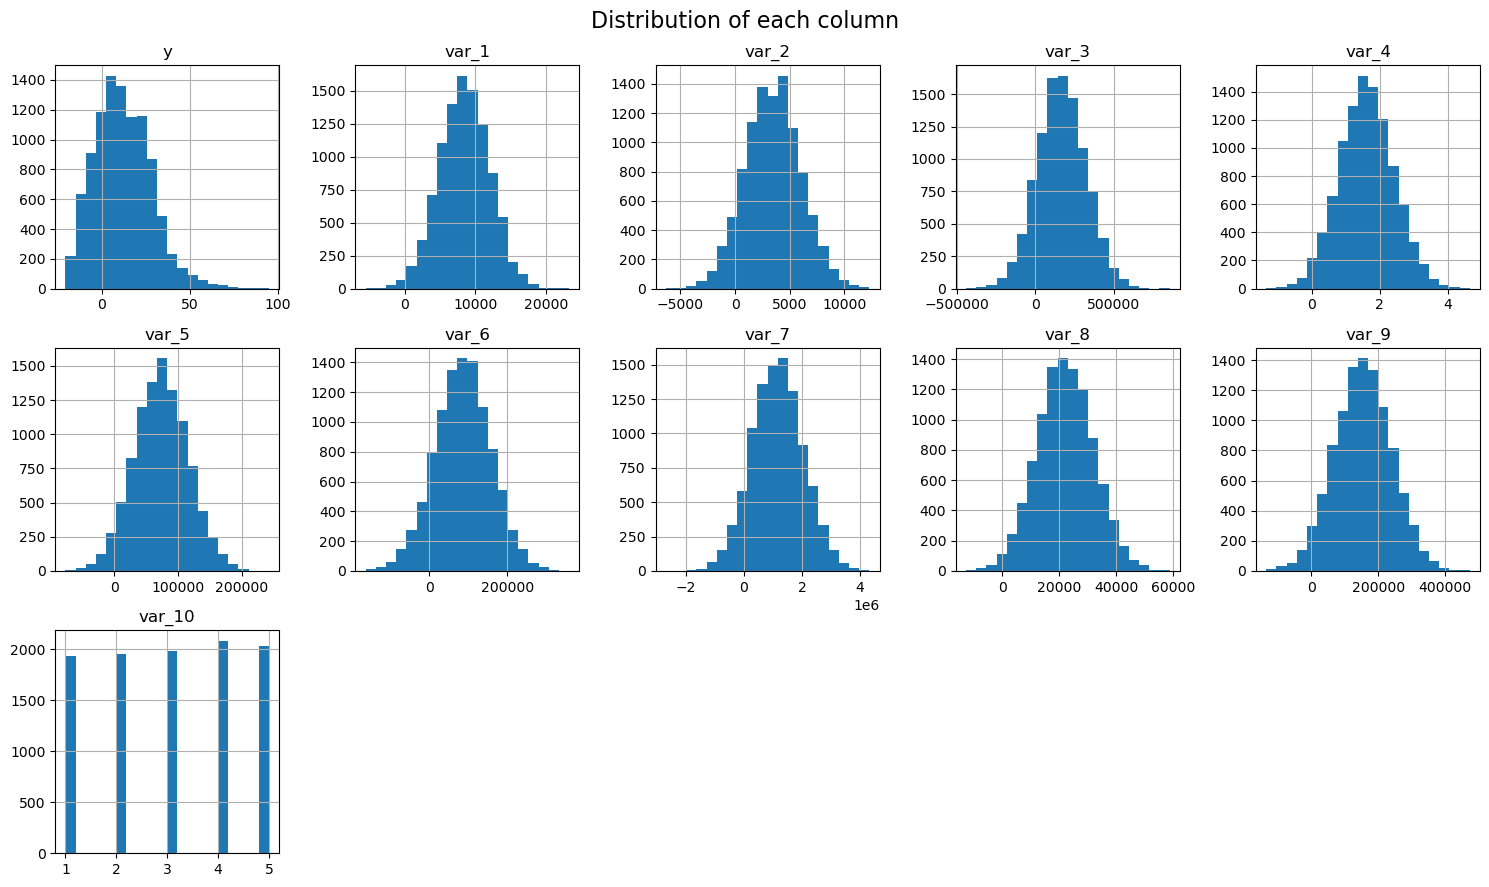

In [6]:
num_cols = len(df.columns)
cols_per_row = 5 #to get 5 graphs per row
num_rows = (num_cols + cols_per_row - 1) // cols_per_row # Calculate required rows

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, 3 * num_rows)) # Adjust figsize as needed
axes = axes.flatten() # Flatten the 2D array of axes for easier iteration

for i, col in enumerate(df.columns):
    ax = axes[i]
    df[col].hist(ax=ax, bins=20) # create a histogram for the given column in loop
    ax.set_title(col)
    ax.set_xlabel('') 
    ax.set_ylabel('') 

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of each column", fontsize=16)

plt.tight_layout()
plt.show()

All of the variables are continuous with a unimodal distributions except for var_10 which is discrete  containing integers from 1-5.  All the integers in var_10 seem to be equally represented.  This raises the question of whether var_10 should be treated like an ordinal feature or a categorical one.


#### Correlation heatmap

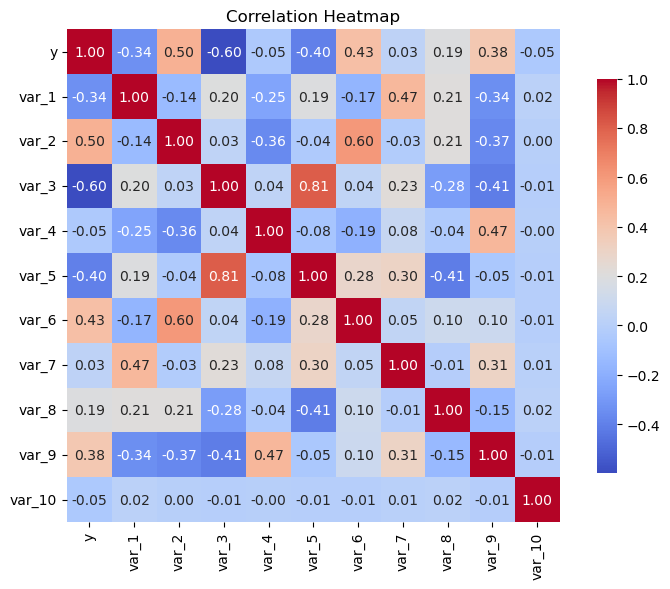

In [7]:
# Compute correlation matrix
corr_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

One thing that stands out here is that var_10 has almost no correlation to any of the other variables.  This leads me to two possible hypothesis.  One is that it is a completely irrelavent variable to everything else.  The second is perhaps it is categorical and not ordinal feature.  We see the values are discrete integers from 1-5.  It could be those are groups and that a higher number doesnt actually correspond to a larger value.  

To test these hypothesis I compared two possibilites for encoding.  One is to do standard scaling for all the variables, and the other is to do standard scaling for the first 9 variables and one hot encoding for var_10.  If var_10 is in fact categorical and not ordinal then it should cause a slight improvement in all the models.

## sklearn pipeline

#### split into test train split

In [8]:
# Split the data into train and test sets (80/20)
X = df[[f"var_{i}" for i in range(1, 11)]]
y = df["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Run grid search cv to choose model and hyperparameters
Models: Linear Regression, Decision Tree, Random Forest, ANN, XGBoost

In [13]:


# 1. Cross-validation setup 
cv = KFold(n_splits=5, shuffle=True, random_state=42) #5 fold cv

# 2. Preprocessing strategies
encoding_configs = {
    "All Scaled": ColumnTransformer([
        ("all", StandardScaler(), [f"var_{i}" for i in range(1, 11)])
    ]),
    "OHE var_10": ColumnTransformer([
        ("num", StandardScaler(), [f"var_{i}" for i in range(1, 10)]),
        ("cat", OneHotEncoder(drop='first', sparse=False), ["var_10"])
    ])
}

# 3. Model definitions and hyperparameters
model_params = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}
    },
    "Lasso": {
        "model": Lasso(),
        "params": {
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            "regressor__max_depth": [3, 5, 10, None],
            "regressor__min_samples_split": [2, 5, 10]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "regressor__n_estimators": [50, 100],
            "regressor__max_depth": [None, 5, 10]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(objective='reg:squarederror', random_state=42),
        "params": {
            "regressor__n_estimators": [50, 100],
            "regressor__max_depth": [3, 5, 7],
            "regressor__learning_rate": [0.01, 0.1, 0.2]
        }
    },
    "ANN (MLP)": {
        "model": MLPRegressor(max_iter=1000, random_state=42),
        "params": {
            "regressor__hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "regressor__alpha": [0.0001, 0.01]
        }
    }
    
}

# 4. Run model grid search across both preprocessing pipelines
results = []

for encoding_name, preprocessor in encoding_configs.items():
    for model_name, mp in model_params.items():
        full_name = f"{model_name} ({encoding_name})"
        print(f"\nRunning GridSearchCV for {full_name}...")

        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("regressor", mp["model"])
        ])

        grid = GridSearchCV(
            pipeline,
            param_grid=mp["params"],
            cv=cv,
            scoring="r2",
            n_jobs=-1
        )

        # Training latency
        start_train = time.time()
        grid.fit(X_train, y_train)
        end_train = time.time()
        training_latency = end_train - start_train

        best_model = grid.best_estimator_

        # Inference latency
        start_infer = time.time()
        y_pred_test = best_model.predict(X_test)
        end_infer = time.time()
        inference_latency = (end_infer - start_infer) / len(X_test)

        # Test metrics
        test_r2 = r2_score(y_test, y_pred_test)
        test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
        model_size_kb = sys.getsizeof(pickle.dumps(best_model)) / 1024

        results.append({
            "Model": full_name,
            "CV Best R²": round(grid.best_score_, 4),
            "Test R²": round(test_r2, 4),
            "Test RMSE": round(test_rmse, 4),
            "Training Latency (s)": round(training_latency, 2),
            "Inference Latency (s/sample)": round(inference_latency, 6),
            "Storage Size (KB)": round(model_size_kb, 2),
            "Best Params": grid.best_params_
        })

# 5. Final results as df
results_df = pd.DataFrame(results).sort_values(by=["Test R²", "Test RMSE"], ascending=[False, True])
print("\nFinished GridSearchCV with preprocessing comparison.")



Running GridSearchCV for Linear Regression (All Scaled)...

Running GridSearchCV for Lasso (All Scaled)...

Running GridSearchCV for Decision Tree (All Scaled)...

Running GridSearchCV for Random Forest (All Scaled)...

Running GridSearchCV for XGBoost (All Scaled)...

Running GridSearchCV for ANN (MLP) (All Scaled)...

Running GridSearchCV for Linear Regression (OHE var_10)...

Running GridSearchCV for Lasso (OHE var_10)...

Running GridSearchCV for Decision Tree (OHE var_10)...

Running GridSearchCV for Random Forest (OHE var_10)...

Running GridSearchCV for XGBoost (OHE var_10)...

Running GridSearchCV for ANN (MLP) (OHE var_10)...

Finished GridSearchCV with preprocessing comparison.


In [14]:
# Display results
pd.set_option('display.max_colwidth', None)
pd.set_option("display.float_format", "{:.4f}".format)
print("\nModel Comparison Results:\n")
results_df


Model Comparison Results:



,Model,CV Best R²,Test R²,Test RMSE,Training Latency (s),Inference Latency (s/sample),Storage Size (KB),Best Params
11,ANN (MLP) (OHE var_10),0.9999,1.0000,0.0806,217.1300,0.0000,50.1200,"{'regressor__alpha': 0.0001, 'regressor__hidden_layer_sizes': (100,)}"
5,ANN (MLP) (All Scaled),0.9999,1.0000,0.0890,257.5700,0.0000,44.3800,"{'regressor__alpha': 0.01, 'regressor__hidden_layer_sizes': (100,)}"
4,XGBoost (All Scaled),0.9952,0.9969,0.8943,16.0800,0.0000,271.8700,"{'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 100}"
10,XGBoost (OHE var_10),0.9954,0.9969,0.8988,14.6800,0.0000,271.6200,"{'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 100}"
9,Random Forest (OHE var_10),0.9889,0.9910,1.5269,36.8500,0.0000,54220.5500,"{'regressor__max_depth': None, 'regressor__n_estimators': 100}"
3,Random Forest (All Scaled),0.9846,0.9866,1.8640,34.9200,0.0000,54225.5400,"{'regressor__max_depth': None, 'regressor__n_estimators': 100}"
8,Decision Tree (OHE var_10),0.9730,0.9764,2.4722,1.9300,0.0000,169.5900,"{'regressor__max_depth': None, 'regressor__min_samples_split': 10}"
2,Decision Tree (All Scaled),0.9660,0.9695,2.8132,1.7300,0.0000,167.2400,"{'regressor__max_depth': None, 'regressor__min_samples_split': 10}"
6,Linear Regression (OHE var_10),0.7949,0.8050,7.1096,0.1100,0.0000,2.4000,{}
0,Linear Regression (All Scaled),0.7683,0.7811,7.5323,6.2700,0.0000,2.0000,{}


As we can see ANN is most accurate while having relatively small storage size and inference latency.  The only downside is training latency.  If the model doesn't need to be retrained frequently then ANN is the best choice.

## Check feature importance

Now that we know ANN is our best model, let's check the feature importance to see if any of the columns are redundant.

In [15]:
# 1. Get the best ANN row (regardless of encoding strategy)
ann_row = results_df[results_df["Model"].str.startswith("ANN")].iloc[0]
ann_model_name = ann_row["Model"]
ann_params = ann_row["Best Params"]

# 2. Determine the correct preprocessor from the model name
if "OHE var_10" in ann_model_name:
    preprocessor = encoding_configs["OHE var_10"]
else:
    preprocessor = encoding_configs["All Scaled"]

# 3. Rebuild the ANN pipeline with the correct preprocessing
best_ann_model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", MLPRegressor(max_iter=1000, random_state=42))
])
best_ann_model.set_params(**ann_params)

# 4. Refit on full training set
best_ann_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['var_1', 'var_2', 'var_3',
                                                   'var_4', 'var_5', 'var_6',
                                                   'var_7', 'var_8', 'var_9']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['var_10'])])),
                ('regressor', MLPRegressor(max_iter=1000, random_state=42))])

ExactExplainer explainer: 101it [00:24,  2.89it/s]                         


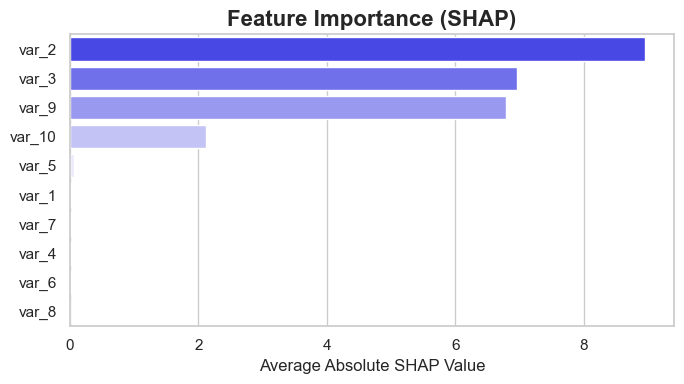

In [16]:
import shap

# 1. Sample test data for SHAP
X_sample = X_test.sample(100, random_state=42)

# 2. Explain predictions using SHAP
explainer = shap.Explainer(best_ann_model.predict, X_sample)
shap_values = explainer(X_sample)

# 3. Calculate mean absolute SHAP values
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
feature_names = shap_values.feature_names

# 4. Create DataFrame for plotting
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Mean |SHAP Value|": mean_abs_shap
}).sort_values(by="Mean |SHAP Value|", ascending=False)

# 5. Plot as horizontal bar chart
# Set style
sns.set(style="whitegrid")
#create figures
plt.figure(figsize=(7, 4))
ax = sns.barplot(
    x="Mean |SHAP Value|", 
    y="Feature", 
    data=importance_df,
    palette="bwr"
)
# Title and labels
ax.set_title("Feature Importance (SHAP)", fontsize=16, weight="bold")
ax.set_xlabel("Average Absolute SHAP Value", fontsize=12)
ax.set_ylabel("")
#plot
plt.tight_layout()
plt.show()


features: "var_5", "var_1", "var_7", "var_6", "var_4", "var_8" seem to offer almost no impact.  It would be therefore advisable to remove them as to reduce model complexity.

### Removing unwanted features

In [17]:

# 1. Drop specified variables
cols_to_drop = ["var_5", "var_1", "var_7", "var_6", "var_4", "var_8"]
X_dropped = X.drop(columns=cols_to_drop)

# 2. Re-split the modified feature set
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_dropped, y, test_size=0.2, random_state=42)

# 3. Reuse ANN model, param grid, and preprocesser from earlier
ann_model = model_params["ANN (MLP)"]["model"]
param_grid = model_params["ANN (MLP)"]["params"]
# Only use columns that were not dropped
numeric_features_reduced = [col for col in [f"var_{i}" for i in range(1, 10)] if col not in cols_to_drop]
categorical_features = ["var_10"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features_reduced),
    ("cat", OneHotEncoder(drop='first', sparse=False), categorical_features)
])

# 4. Build pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", ann_model)
])

# 5. GridSearchCV with 5-fold CV
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring="r2", n_jobs=-1)

# 6. Fit and time
start_train = time.time()
grid.fit(X_train_d, y_train_d)
end_train = time.time()
training_latency = end_train - start_train

best_ann_model_d = grid.best_estimator_

# 7. Inference and timing
start_infer = time.time()
y_pred_test_d = best_ann_model_d.predict(X_test_d)
end_infer = time.time()
inference_latency = (end_infer - start_infer) / len(X_test_d)

# 7. Metrics
test_r2 = r2_score(y_test_d, y_pred_test_d)
test_rmse = mean_squared_error(y_test_d, y_pred_test_d, squared=False)

# 8. Model size
model_size_kb = sys.getsizeof(pickle.dumps(best_ann_model_d)) / 1024

# 9. Store result in consistent format
reduced_result_df = pd.DataFrame([{
    "Model": "ANN (Reduced Features)",
    "CV Best R²": round(grid.best_score_, 4),
    "Test R²": round(test_r2, 4),
    "Test RMSE": round(test_rmse, 4),
    "Training Latency (s)": round(training_latency, 2),
    "Inference Latency (s/sample)": round(inference_latency, 6),
    "Storage Size (KB)": round(model_size_kb, 2),
    "Best Params": grid.best_params_
}])



print("\nFinished GridSearchCV")

reduced_result_df


Finished GridSearchCV


,Model,CV Best R²,Test R²,Test RMSE,Training Latency (s),Inference Latency (s/sample),Storage Size (KB),Best Params
0,ANN (Reduced Features),1.0000,1.0000,0.0755,202.5200,0.0000,23.7000,"{'regressor__alpha': 0.01, 'regressor__hidden_layer_sizes': (50,)}"


### Comparison after removing unwanted features

In [18]:
# Display comparison of results with and without feature reduction

# 1.select original ANN results
original_row = results_df[results_df["Model"].str.startswith("ANN")].iloc[[0]]

# 2.concatenate original with the reduced-feature model 
comparison_df = pd.concat([
    original_row,
    reduced_result_df
], ignore_index=True)

# 3. Display
pd.set_option("display.float_format", "{:.4f}".format)
pd.set_option('display.max_colwidth', None)
print("\nComparison of Original vs Reduced-Feature ANN:\n")
comparison_df


Comparison of Original vs Reduced-Feature ANN:



,Model,CV Best R²,Test R²,Test RMSE,Training Latency (s),Inference Latency (s/sample),Storage Size (KB),Best Params
0,ANN (MLP) (OHE var_10),0.9999,1.0000,0.0806,217.1300,0.0000,50.1200,"{'regressor__alpha': 0.0001, 'regressor__hidden_layer_sizes': (100,)}"
1,ANN (Reduced Features),1.0000,1.0000,0.0755,202.5200,0.0000,23.7000,"{'regressor__alpha': 0.01, 'regressor__hidden_layer_sizes': (50,)}"


As we can see dropping features that had little importance improved the model in every way.  It has better r2, rmse, training latency, inference latency, and is smaller.

## Shapley Analysis

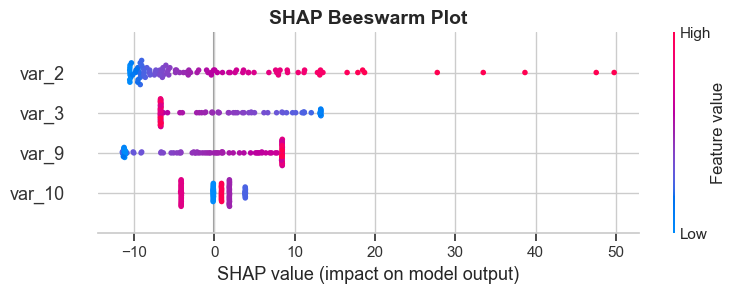

In [19]:
# Define reduced feature set (exclude dropped columns)
cols_to_drop = ["var_1", "var_4", "var_5", "var_6", "var_7", "var_8"]
X_test_d = X_test.drop(columns=cols_to_drop)

# Sample 100 for explanation
X_sample_d = X_test_d.sample(100, random_state=42)

# SHAP explainer 
explainer = shap.Explainer(best_ann_model_d.predict, X_sample_d)
shap_values = explainer(X_sample_d)

# Create the beeswarm plot
plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values, max_display=10, show=False)

# Add title
plt.title("SHAP Beeswarm Plot", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

#### How to Read the SHAP Beeswarm Plot
- **Each dot** represents a single prediction for a sample.
- **Color** indicates the feature value:
  - **<span style="color:red">Red</span>** = high value
  - **<span style="color:blue">Blue</span>** = low value
- **Horizontal position** shows the SHAP value:
  - A positive SHAP value means the feature **increased** the model’s prediction.
  - A negative SHAP value means the feature **decreased** the model’s prediction.
- **Features are ranked top to bottom** by their overall importance (mean absolute SHAP value).
- The **spread of dots** across the x-axis shows how much variability the feature has in influencing different predictions.
> This plot helps you understand not just which features matter most, but also how they affect the model’s output.

### Interpretation of the Beeswarm
- For `var_2` and `var_9`higher values directly lead to a higher y.  
- For `var_3` we see the exact opposite. Higher values lead to a lower y output.
- For `var_10`we see the impact is very consistent with the group. Group 1 has no impact on y whereas group 4 will decrease y by about 4-5

## Permutation Sanity Check

In [20]:
rng = np.random.RandomState(0)
y_perm = y_train.sample(frac=1.0, random_state=rng).reset_index(drop=True)
X_train_perm = X_train.reset_index(drop=True)

perm_model = grid.best_estimator_  # or rebuild the same architecture
perm_model.fit(X_train_perm, y_perm)
perm_r2 = r2_score(y_test, perm_model.predict(X_test))
print("Permutation test R² (should be ~0 or negative):", perm_r2)


Permutation test R² (should be ~0 or negative): 0.0009957143232478538


## Conclusion

After an extensive evaluation of multiple regression models and preprocessing strategies, we conclude the following:

####  Best Overall Model
**Artificial Neural Network** emerged as the top-performing model, achieving the highest test R² and lowest RMSE across all evaluated options, all while being a relatively compact model. However, it did have a slow training time.  If the model needs to frequently be retrained it might be better to choose xgboost.

#### Key Findings
- **Preprocessing:** Treating `var_10` as a categorical variable using one-hot encoding improved model performance compared to standard scaling across all models.
- **Feature Selection:** Removing low-importance variables (`var_1`, `var_4`, `var_5`, `var_6`, `var_7`, `var_8`) had not only a minimal impact on performance but actually slightly improved it, suggesting that a more compact and efficient model is superior.
- **Model Comparison:**
  - **XGBoost** provided the best balance between performance and training time.
  - **Random Forest** were interpretable but far too slow and large.
  - **Decision Tree** were very interpretable and fairly accurate.  This could be a good choice if interpretability is of top priority.
  - **Linear Regression** as the simplest model it was the least accurate.
  
#### Interpretability
SHAP analysis confirmed that a small subset of features (especially `var_2`) had a disproportionately large influence on predictions. This supports their continued use and may guide future feature selection or simplification.

---

### Recommendation

Deploy the **ANN model** with one-hot encoding for `var_10` as the primary pipeline. Consider excluding low-importance features to reduce storage and latency without sacrificing accuracy. Incorporate monitoring practices to ensure accuracy remains above the client defined threshold.
